In [2]:
! python -m pip uninstall tensorflow -y
! python -m pip uninstall keras -y
! pip install tensorflow==2.15.0
! pip install keras==2.15.0
! pip install tensorflow-addons==0.23.0
! pip install nltk==3.8.1
! pip install datasets
! pip install matplotlib scikit-learn
! pip install -U accelerate
! pip install huggingface_hub

Found existing installation: tensorflow 2.15.0
Uninstalling tensorflow-2.15.0:
  Successfully uninstalled tensorflow-2.15.0
Found existing installation: keras 3.2.1
Uninstalling keras-3.2.1:
  Successfully uninstalled keras-3.2.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 47.8 MB/s eta 0:00:00:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 16.6 MB/s eta 0:00:0000:01
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.1.5
    Uninstalling typeguard-4.1.5:
      Successfully uninstalled typeguard-4.1.5
ERROR: pip's dependency resolver does not currently take into account all the packages that a

Login to Huggingface with api key

In [1]:
from huggingface_hub import login
login()

1. Dataset download and preparation
- Used  [facebook/pmd - coco](https://huggingface.co/datasets/facebook/pmd) dataset
- coco (specific set of PMD) is around 85 GB and has 566747 train images and 25010 validation images
- As dataset size is huge, I have used 16000 images to train and 1600 images to test

In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_text as text
import tensorflow_addons as tfa
import nltk
from concurrent.futures import ThreadPoolExecutor
from functools import partial
import io
import urllib
import PIL.Image
import datasets
from datasets.utils.file_utils import get_datasets_user_agent
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import re
import os
import time
import json

USER_AGENT = get_datasets_user_agent()
nltk.download('wordnet')

def fetch_single_image(image_data, timeout=None, retries=0):
    image_url, image = image_data
    if image is not None:
        return image

    for _ in range(retries + 1):
        try:
            request = urllib.request.Request(
                image_url,
                data=None,
                headers={"user-agent": USER_AGENT},
            )
            with urllib.request.urlopen(request, timeout=timeout) as req:
                image = PIL.Image.open(io.BytesIO(req.read()))
            break
        except Exception:
            image = None
    return image


def fetch_images(batch, num_threads, timeout=None, retries=0):
    fetch_single_image_with_args = partial(fetch_single_image, timeout=timeout, retries=retries)
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        batch["image"] = list(executor.map(fetch_single_image_with_args, zip(batch["image_url"], batch["image"])))
    return batch

def download_dataset():
    num_threads = 50
    pmd = datasets.load_dataset("facebook/pmd", 'coco', use_auth_token=True, trust_remote_code=True)
    pmd = pmd.map(fetch_images, batched=True, batch_size=100, fn_kwargs={"num_threads": num_threads})
    return pmd

sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
if tf.config.list_physical_devices("GPU"):
    print("On GPU:")
    with tf.device("/device:GPU:0"):
        pmd = download_dataset()
else:
    print("On CPU:")
    pmd = download_dataset()
# pmd.save_to_disk("./pmd_dataset/")

2024-05-03 03:39:53.117544: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-03 03:39:53.117592: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-03 03:39:53.118994: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our Tens

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0

On GPU:


/opt/conda/lib/python3.10/site-packages/datasets/load.py:2516: FutureWarning: 'use_auth_token' was deprecated in favor of 'token' in version 2.14.0 and will be removed in 3.0.0.
You can remove this warning by passing 'token=<use_auth_token>' instead.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/566747 [00:00<?, ? examples/s]

Map:   0%|          | 0/25010 [00:00<?, ? examples/s]

In [3]:
# pmd = datasets.load_from_disk("pmd_dataset/")
pmd_train = pmd['train']
pmd_val = pmd['validation']
print(len(pmd_train))
print(len(pmd_val))

566747
25010


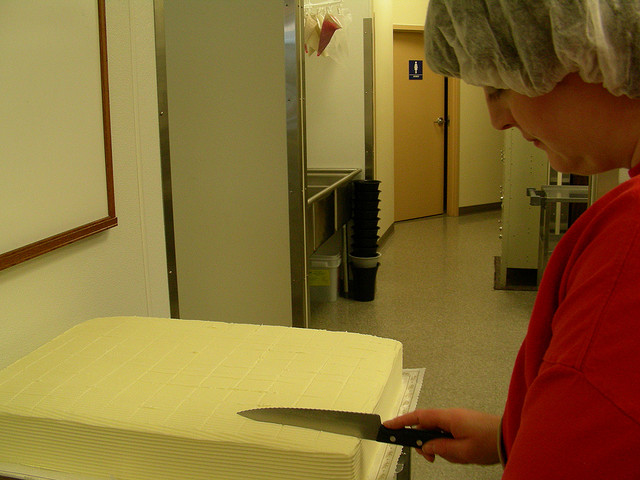

Caption: A woman wearing a net on her head cutting a cake. 


In [4]:
for row in pmd_train.to_iterable_dataset():
    im = row['image']
    display(im)
    print("Caption: " + row['text'])
    metadata = json.loads(row['meta'])
    image_path = metadata['image_path']
    break

In [5]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

# lists to store the captions and image_paths
all_train_img_captions = []
all_train_img_paths = []
all_val_img_captions = []
all_val_img_paths = []

def convert_dataset_to_list():
    for row in pmd_train.to_iterable_dataset():
        caption = '<start> ' + row['text'] + ' <end>'
        metadata = json.loads(row['meta'])
        image_path = metadata['image_path']
        all_train_img_captions.append(caption)
        all_train_img_paths.append(image_path)

    for row in pmd_val.to_iterable_dataset():
        caption = '<start> ' + row['text'] + ' <end>'
        metadata = json.loads(row['meta'])
        image_path = metadata['image_path']
        all_val_img_captions.append(caption)
        all_val_img_paths.append(image_path)


if tf.config.list_physical_devices("GPU"):
    print("On GPU:")
    with tf.device("/device:GPU:0"):
        convert_dataset_to_list()
else:
    print("On CPU:")
    convert_dataset_to_list()

# to set random states we shuffle the captions and image_paths together
train_img_captions, train_img_paths = shuffle(all_train_img_captions, all_train_img_paths, random_state=1)

# to set random states we shuffle the captions and image_paths together
val_img_captions, val_img_paths = shuffle(all_val_img_captions, all_val_img_paths, random_state=1)
print('\nTrain Dataset Sample')
print(train_img_captions[:5])
print(train_img_paths[:5])
print('\nTest Dataset Sample')
print(val_img_captions[:5])
print(val_img_paths[:5])

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0

On GPU:

Train Dataset Sample
['<start> Several beautiful brown horses running through the meadow. <end>', '<start> Bed covered in stuffed animals with hello kitty bedding.  <end>', '<start> Two women carving up a pizza in a kitchen <end>', '<start> A very large building with a large clock on it . <end>', '<start> A red kite is being flown in a crowded park.  <end>']
['/root/.cache/huggingface/datasets/downloads/extracted/ca733e0e000fb2d7a09fbcc94dbfe7b5a30750681d0e965f8e0a23b1c2f98c75/val2014/COCO_val2014_000000549225.jpg', '/root/.cache/huggingface/datasets/downloads/extracted/2037d38f39f82fa2a51cedd39e325fcf7e806a356ea23774c16422f6a6c3514c/train2014/COCO_train2014_000000147392.jpg', '/root/.cache/huggingface/datasets/downloads/extracted/2037d38f39f82fa2a51cedd39e325fcf7e806a356ea23774c16422f6a6c3514c/train2014/COCO_train2014_000000

In [6]:
train_img_captions = train_img_captions[:16000]
train_img_paths = train_img_paths[:16000]

val_img_captions = val_img_captions[:1600]
val_img_paths = val_img_paths[:1600]

print(len(train_img_captions))
print(len(val_img_captions))

16000
1600


2. Image feature extraction using InceptionV3 CNN model

In [7]:
from tensorflow.keras.applications.inception_v3 import preprocess_input

def load_image_from_path(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (299, 299))
    image = preprocess_input(image)
    return image, image_path

In [8]:
from tensorflow.keras.applications import InceptionV3

image_model = InceptionV3(include_top=False, weights='imagenet')

image_features_extract_model_input = image_model.input
image_features_extract_model_hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(image_features_extract_model_input, image_features_extract_model_hidden_layer)

87910968/87910968 [==============================] - 3s 0us/step


In [9]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
encoder_train = sorted(set(train_img_paths))
encoder_val = sorted(set(val_img_paths))

def feature_extraction_driver(encoder_set):
    # load all images
    image_path_dataset = tf.data.Dataset.from_tensor_slices(encoder_set).map(load_image_from_path).batch(16)
    # feature extraction
    for image, image_path in image_path_dataset:
        batch_features = image_features_extract_model(image)
        batch_features = tf.reshape(batch_features, (batch_features.shape[0], -1, batch_features.shape[3]))

        # save the features to disk
        for bf, p in zip(batch_features, image_path):
            path_of_feature = p.numpy().decode("utf-8")
            np.save(path_of_feature, bf.numpy())

def extract_features(encoder_set):
    if tf.config.list_physical_devices("GPU"):
        print("On GPU:")
        feature_extraction_driver(encoder_set)
    else:
        print("On CPU:")
        feature_extraction_driver(encoder_set)
        
extract_features(encoder_train)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0

On GPU:


3. Tokenization of dataset using Tensorflow Tokenizer

In [10]:
def calculate_maximum_length(tensor):
  return max(len(sequence) for sequence in tensor)

def tokenize_captions(caption_dataset):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token="<unk>", filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')

    tokenizer.fit_on_texts(caption_dataset)

    tokenizer.word_index = {key:value for key, value in tokenizer.word_index.items()}
    # use <unk> token in the word2idx dictionary to mark out-of-vocabulary token
    tokenizer.word_index[tokenizer.oov_token] = len(caption_dataset) + 1
    tokenizer.word_index['<pad>'] = 0

    # create tokenized vectors
    sequences = tokenizer.texts_to_sequences(caption_dataset)

    # reverse mapping (index -> word)
    index_word = {value:key for key, value in tokenizer.word_index.items()}

    # pad each vector so that every caption is of size max_length
    caption_vector = tf.keras.preprocessing.sequence.pad_sequences(sequences, padding='post')

    # calculating the max_length used to store the attention weights
    maximum_length = calculate_maximum_length(sequences)

    return tokenizer, sequences, index_word, caption_vector, maximum_length

sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
train_tokenizer, train_sequences, train_index_word, train_caption_vector, train_maximum_length = tokenize_captions(train_img_captions)

print(train_img_captions[0])
print(train_caption_vector[0])

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0

<start> Several beautiful brown horses running through the meadow. <end>
[   3   92  418  113  188  340  103    7 1118    4    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0]


In [11]:
print ("No of Training Images:",len(train_img_paths))
print ("No of Training Caption: ",len(train_img_captions))
print ("No of Test Images",len(val_img_paths))
print ("No of Test Caption:",len(val_img_captions))

No of Training Images: 16000
No of Training Caption:  16000
No of Test Images 1600
No of Test Caption: 1600


4. Defining Hyperparameters

In [12]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dimension = 256
units = 512
vocab_size = len(train_tokenizer.word_index)

# shape of the vector extracted from Inception-V3 is (64, 2048)
features_shape = 2048
attention_features_shape = 64

5. Dataset mapping and batch creation

In [13]:
def map_func(image_path, caption):
    image_name = image_path.numpy().decode('utf-8')  # Convert EagerTensor to string
    image_tensor = np.load(image_name + '.npy')  # Load numpy file
    return image_tensor.astype(np.float32), caption

def map_dataset(dataset):
    return dataset.map(lambda item1, item2: tf.py_function(map_func, [item1, item2], [tf.float32, tf.int32]), num_parallel_calls=tf.data.experimental.AUTOTUNE)

print("Load dataset")
dataset = tf.data.Dataset.from_tensor_slices((train_img_paths, train_caption_vector))

sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
if tf.config.list_physical_devices("GPU"):
    print("On GPU:")
    with tf.device("/device:GPU:0"):
        dataset = map_dataset(dataset)
else:
    dataset = map_dataset(dataset)

print (" shuffling and batching")
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(1)

Load dataset
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0

On GPU:
 shuffling and batching


6. Model Defination
- CNN Encoder
- RNN Decoder - Gated Recurrent Unit (GRU)
- BahdanauAttention for RNN Decoder

In [14]:
def gru(units):
    if tf.test.is_gpu_available():
        print("Using CuDNNGRU because CuDNNGRU layer provides a significant speedup")
        return tf.compat.v1.keras.layers.CuDNNGRU (units,
                                    return_sequences=True,
                                    return_state=True,
                                    recurrent_initializer='glorot_uniform')
    else:
        print("Using GRU")
        return tf.keras.layers.GRU(units,
                               return_sequences=True,
                               return_state=True,
                               recurrent_activation='sigmoid',
                               recurrent_initializer='glorot_uniform')

class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # features(CNN_encoder output) shape == (batch_size, 64, embedding_dimension)
        # hidden shape == (batch_size, hidden_size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # score shape == (batch_size, 64, hidden_size)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

        # attention_weights shape == (batch_size, 64, 1)
        # we get 1 at the last axis because we are applying score to self.V
        attention_weights = tf.nn.softmax(self.V(score), axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

class CNN_Encoder(tf.keras.Model):
    # Since we have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dimension):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dimension)
        self.fc = tf.keras.layers.Dense(embedding_dimension)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x


class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dimension, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dimension)
        self.gru = gru(self.units)
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        # defining attention as a separate model
        context_vector, attention_weights = self.attention(features, hidden)

        # x shape after passing through embedding == (batch_size, 1, embedding_dimension)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dimension + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # shape == (batch_size, max_length, hidden_size)
        x = self.fc1(output)

        # x shape == (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))

        # output shape == (batch_size * max_length, vocab)
        x = self.fc2(x)

        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

def loss_function(real, pred):
    mask = 1 - np.equal(real, 0)
    loss_ = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=real, logits=pred) * mask
    return tf.reduce_mean(loss_)

In [15]:
print("Loading Encoder\n")
encoder = CNN_Encoder(embedding_dimension)

print("Loading Decoder")
decoder = RNN_Decoder(embedding_dimension, units, vocab_size)

optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)

Loading Encoder

Loading Decoder
Using CuDNNGRU because CuDNNGRU layer provides a significant speedup


In [ ]:
# import os
# for dirname, _, filenames in os.walk('/kaggle/working'):
#     for filename in filenames:
#         filename = os.path.join(dirname, filename)
#         f = filename
#         if len(filename.split('/')) > 4:
#              os.remove(os.path.join(dirname, f))

7. Training the model

In [16]:
# checkpoint_dir = './image_caption_model'
# checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
# checkpoint = tf.train.Checkpoint(
#                                  optimizer=optimizer,
#                                  encoder=encoder,
#                                  decoder=decoder,
#                                 )

EPOCHS = 10
loss_plot = []

def run_epoch():
    for epoch in range(EPOCHS):
        start = time.time()
        total_loss = 0

        for (batch, (image_tensor, target)) in enumerate(dataset):
            loss = 0

            # initializing the hidden state for each batch
            # because the captions are not related from image to image
            hidden = decoder.reset_state(batch_size=target.shape[0])
            decoder_input = tf.expand_dims([train_tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

            with tf.GradientTape() as tape:
                features = encoder(image_tensor)
                for i in range(1, target.shape[1]):
                    # passing the features through the decoder
                    predictions, hidden, _ = decoder(decoder_input, features, hidden)

                    loss += loss_function(target[:, i], predictions)

                    # using teacher forcing
                    decoder_input = tf.expand_dims(target[:, i], 1)

            total_loss += (loss / int(target.shape[1]))
            variables = encoder.variables + decoder.variables
            gradients = tape.gradient(loss, variables)
            optimizer.apply_gradients(zip(gradients, variables))

#             if batch % 100 == 0:
#                 checkpoint.save(file_prefix = checkpoint_prefix)

        # storing the epoch end loss value to plot later
        loss_plot.append(total_loss / len(train_caption_vector))

        print ('Epoch {} Loss {:.6f}'.format(epoch + 1, total_loss/len(train_caption_vector)))
        print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
if tf.config.list_physical_devices("GPU"):
    print("On GPU:")
    with tf.device("/device:GPU:0"):
        run_epoch()
else:
    run_epoch()

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0

On GPU:
Epoch 1 Loss 0.017094
Time taken for 1 epoch 507.72977447509766 sec

Epoch 2 Loss 0.012910
Time taken for 1 epoch 505.4685380458832 sec

Epoch 3 Loss 0.011493
Time taken for 1 epoch 511.86067819595337 sec

Epoch 4 Loss 0.010628
Time taken for 1 epoch 506.5695149898529 sec

Epoch 5 Loss 0.009958
Time taken for 1 epoch 506.6797752380371 sec

Epoch 6 Loss 0.009363
Time taken for 1 epoch 507.80741143226624 sec

Epoch 7 Loss 0.008813
Time taken for 1 epoch 511.2153239250183 sec

Epoch 8 Loss 0.008290
Time taken for 1 epoch 517.7804663181305 sec

Epoch 9 Loss 0.007808
Time taken for 1 epoch 506.8617105484009 sec

Epoch 10 Loss 0.007312
Time taken for 1 epoch 510.0408365726471 sec



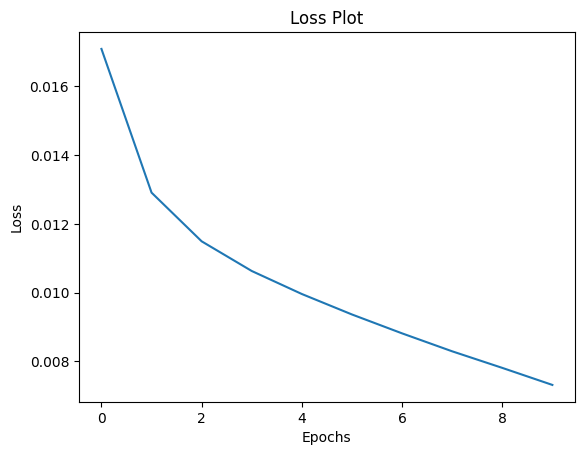

In [17]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [ ]:
# checkpoint_dir = './image_caption_model'
# checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
# checkpoint = tf.train.Checkpoint(
#                                  optimizer=optimizer,
#                                  encoder=encoder,
#                                  decoder=decoder,
#                                 )

# checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

8. Evaluating the model

In [18]:
def evaluate_argmax_search(image):
    attention_plot = np.zeros((train_maximum_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image_from_path(image)[0], 0)
    test_image_tensor = image_features_extract_model(temp_input)
    test_image_tensor = tf.reshape(test_image_tensor, (test_image_tensor.shape[0], -1, test_image_tensor.shape[3]))

    features = encoder(test_image_tensor)

    decoder_input = tf.expand_dims([train_tokenizer.word_index['<start>']], 0)
    result = ['<start>']

    for i in range(train_maximum_length):
        predictions, hidden, attention_weights = decoder(decoder_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append(train_index_word[predicted_id])

        if train_index_word[predicted_id] == '<end>':
            return result, attention_plot

        decoder_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [31]:
def evaluate_beam_search(image, beam_index=3):
    start = [train_tokenizer.word_index['<start>']]
    
    start_word = [[start, 0.0]]
    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image_from_path(image)[0], 0)
    test_image_tensor = image_features_extract_model(temp_input)
    test_image_tensor = tf.reshape(test_image_tensor, (test_image_tensor.shape[0], -1, test_image_tensor.shape[3]))
    features = encoder(test_image_tensor)
    while len(start_word[0][0]) < train_maximum_length:
        temp = []
        for s in start_word:
            decoder_input = tf.expand_dims([s[0][-1]], 0)
            preds, hidden, _ = decoder(decoder_input, features, hidden)
            word_preds = np.argsort(preds[0])[-beam_index:]

            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1].numpy())
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [train_index_word[i] for i in start_word]
    final_caption = []
    
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)
        else:
            break
    final_caption.append('<end>')
    return final_caption

9. Greedy Search (Argmax) - Image Caption Generation
- Argmax Search is where the maximum value index(argmax) in the maximum_length (46 in this case) long predicted vector is extracted and appended to the result. This is done until we hit end_token or the maximum length of the caption.

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0

On GPU:

Real Caption: <start> A young man riding a skateboard down a street. <end>
Prediction Caption (Argmax): <start> a man riding a skateboard down a road <end>


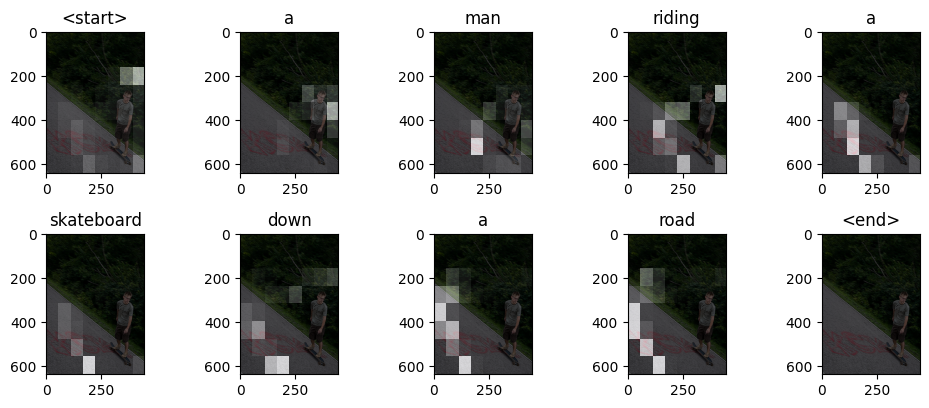


Real Caption: <start> a close up of a cat on a desk near a sandwich  <end>
Prediction Caption (Argmax): <start> a cat is sitting on a table <end>


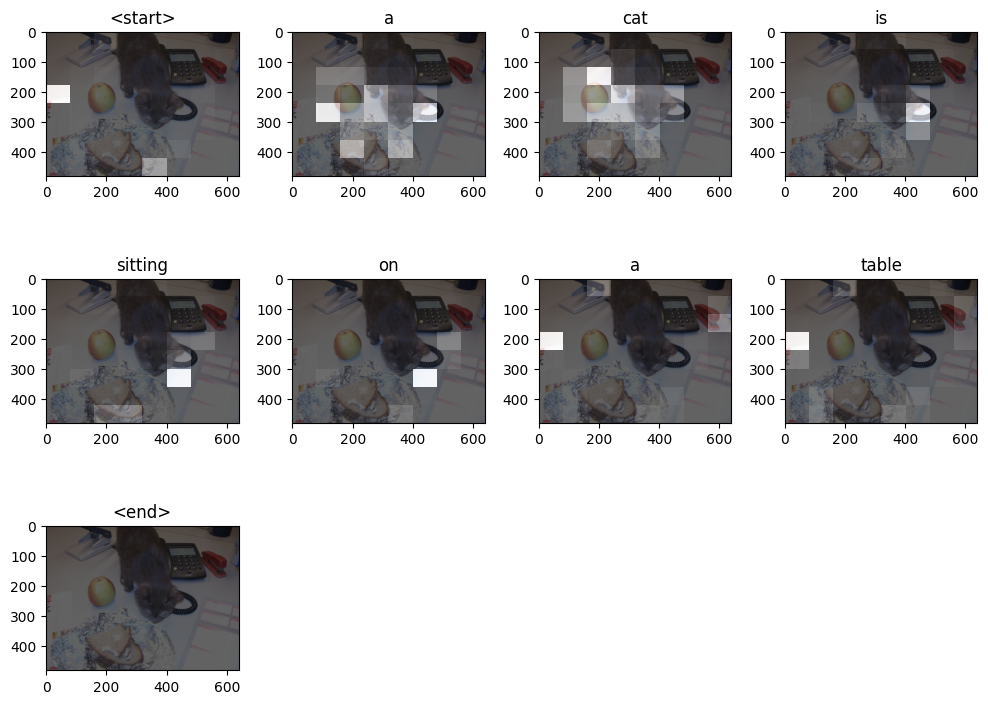


Real Caption: <start> A silver hippy van and a bus for vegans. <end>
Prediction Caption (Argmax): <start> a car parked in a parking lot <end>


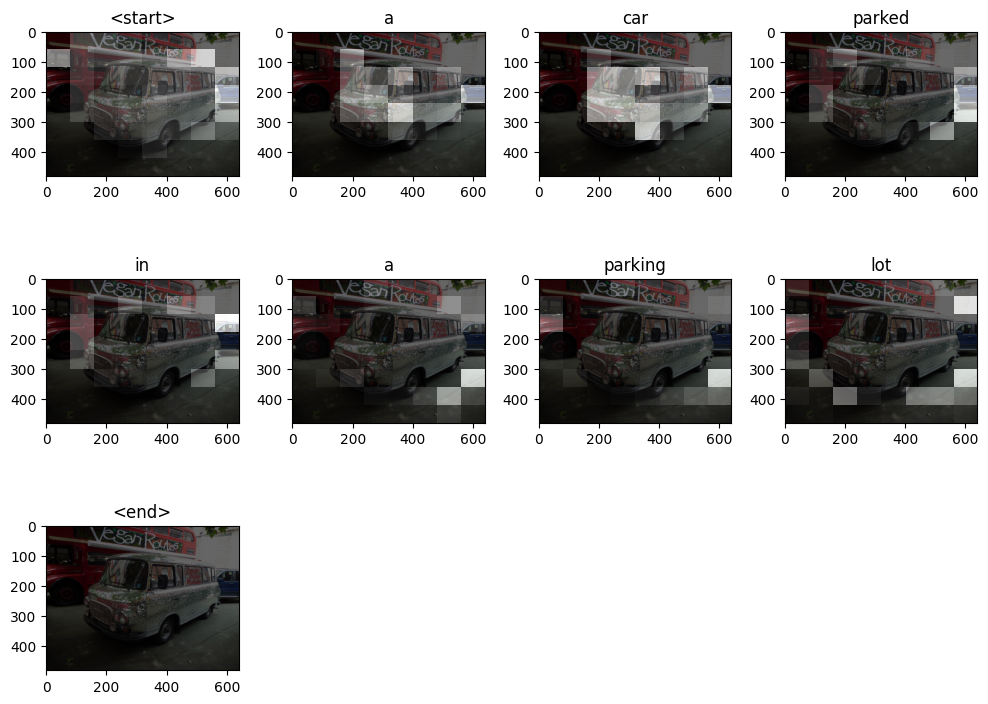


Real Caption: <start> a red and gray bus stopped at the bus stop <end>
Prediction Caption (Argmax): <start> a double decker bus on a street <end>


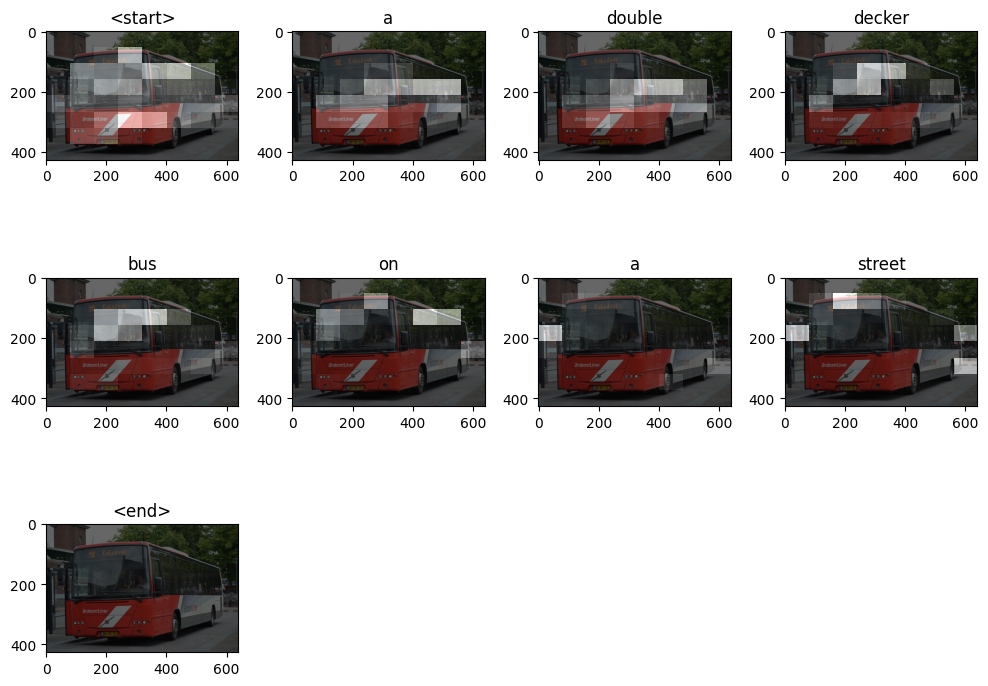


Real Caption: <start> A plate of pasta in a bowl at a restaurant.  <end>
Prediction Caption (Argmax): <start> a table with plates of food on a plate <end>


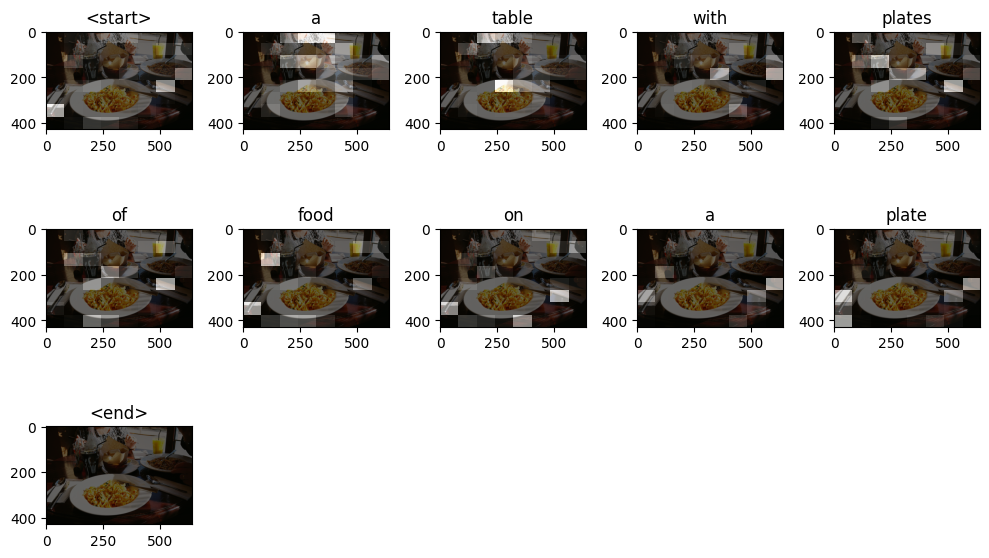

[['<start>', 'a', 'man', 'riding', 'a', 'skateboard', 'down', 'a', 'road', '<end>'], ['<start>', 'a', 'cat', 'is', 'sitting', 'on', 'a', 'table', '<end>'], ['<start>', 'a', 'car', 'parked', 'in', 'a', 'parking', 'lot', '<end>'], ['<start>', 'a', 'double', 'decker', 'bus', 'on', 'a', 'street', '<end>'], ['<start>', 'a', 'table', 'with', 'plates', 'of', 'food', 'on', 'a', 'plate', '<end>']]


In [27]:
def plot_attention(image, result, attention_plot):
    try:
        temp_image = np.array(PIL.Image.open(image))

        fig = plt.figure(figsize=(10, 10))

        len_result = len(result)
        for l in range(len_result):
            temp_att = np.resize(attention_plot[l], (8, 8))
            ax = fig.add_subplot(len_result//2, len_result//2, l+1)
            ax.set_title(result[l])
            img = ax.imshow(temp_image)
            ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

        plt.tight_layout()
        plt.show()
    except:
        plt.close()
        print('Cannot plot this prediction')

def evaulate_argmax():
    i = 0
    generated_captions_argmax = []
    for test_image, test_image_caption in zip(val_img_paths, val_img_captions):
        predicted_caption, attention_plot = evaluate_argmax_search(test_image)
        generated_captions_argmax.append(predicted_caption)
        if i < 5:
            print ('\nReal Caption:', test_image_caption)
            print ('Prediction Caption (Argmax):', ' '.join(predicted_caption))
            plot_attention(test_image, predicted_caption, attention_plot)
        i = i + 1
    return generated_captions_argmax

sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
generated_captions_argmax = []
if tf.config.list_physical_devices("GPU"):
    print("On GPU:")
    with tf.device("/device:GPU:0"):
        generated_captions_argmax = evaulate_argmax()
else:
    generated_captions_argmax = evaulate_argmax()
    
print(generated_captions_argmax[:5])

10. Beam Search - Image Caption Generation
- We take top k predictions (i.e. beam_index - 3 in this case), feed them again in the model and then sort them using the probabilities returned by the model. So, the list will always contain the top k predictions. In the end, we take the one with the highest probability and go through it till we encounter end_token or reach the maximum caption length.

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0

On GPU:

Real Caption: <start> A young man riding a skateboard down a street. <end>
Prediction Caption - Beam Search, width = 3: <start> a skateboard down a street <end>


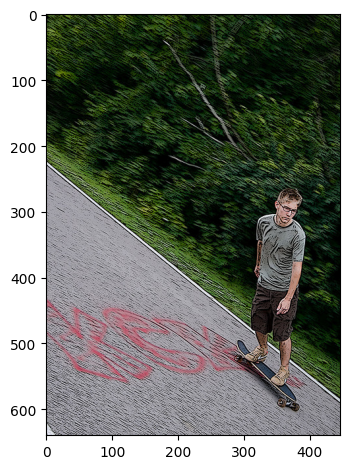


Real Caption: <start> a close up of a cat on a desk near a sandwich  <end>
Prediction Caption - Beam Search, width = 3: <start> a cat sitting next to a white plate <end>


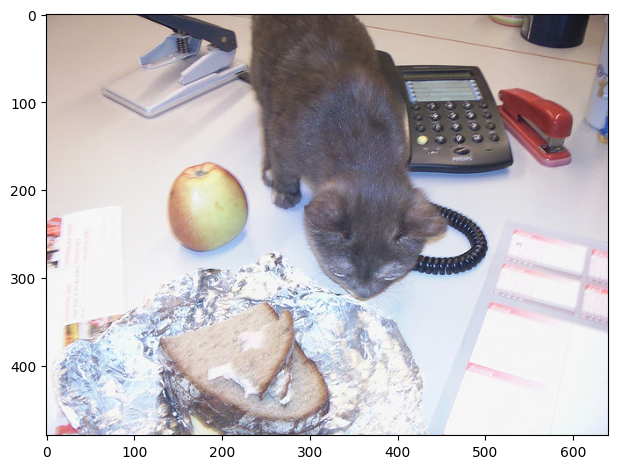


Real Caption: <start> A silver hippy van and a bus for vegans. <end>
Prediction Caption - Beam Search, width = 3: <start> an image of a parking lot <end>


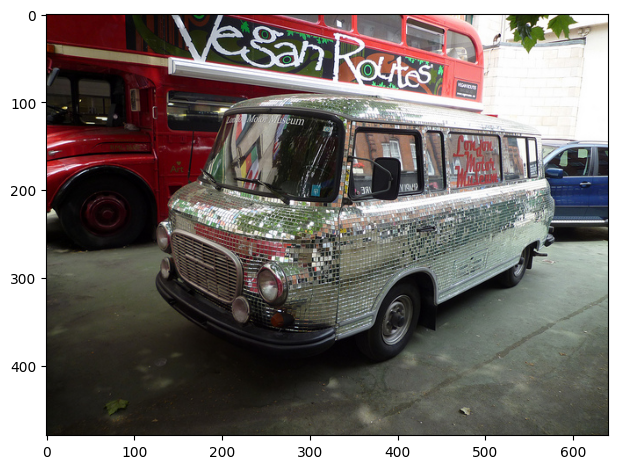


Real Caption: <start> a red and gray bus stopped at the bus stop <end>
Prediction Caption - Beam Search, width = 3: <start> a double decker feel with a street <end>


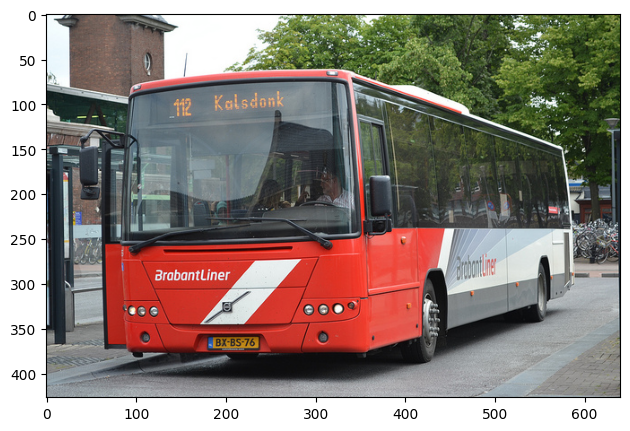


Real Caption: <start> A plate of pasta in a bowl at a restaurant.  <end>
Prediction Caption - Beam Search, width = 3: <start> a group of food on top of paper plate on a plate on top of paper plate on a plate on a plate on top of paper plate on a plate on a plate on top of paper plate on a plate on a plate on top of a plate <end>


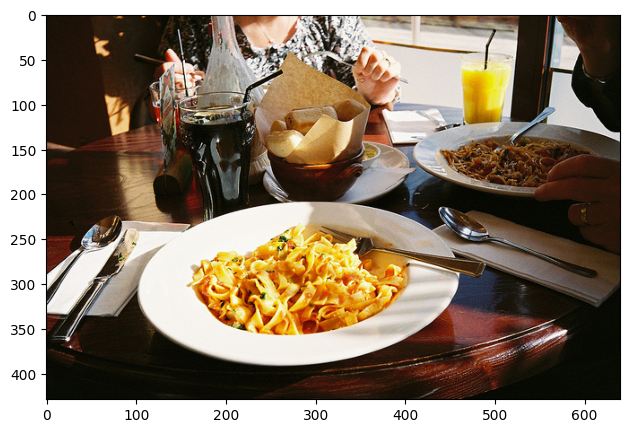

[['<start>', 'a', 'skateboard', 'down', 'a', 'street', '<end>'], ['<start>', 'a', 'cat', 'sitting', 'next', 'to', 'a', 'white', 'plate', '<end>'], ['<start>', 'an', 'image', 'of', 'a', 'parking', 'lot', '<end>'], ['<start>', 'a', 'double', 'decker', 'feel', 'with', 'a', 'street', '<end>'], ['<start>', 'a', 'group', 'of', 'food', 'on', 'top', 'of', 'paper', 'plate', 'on', 'a', 'plate', 'on', 'top', 'of', 'paper', 'plate', 'on', 'a', 'plate', 'on', 'a', 'plate', 'on', 'top', 'of', 'paper', 'plate', 'on', 'a', 'plate', 'on', 'a', 'plate', 'on', 'top', 'of', 'paper', 'plate', 'on', 'a', 'plate', 'on', 'a', 'plate', 'on', 'top', 'of', 'a', 'plate', '<end>']]


In [34]:
def evaluate_beam():
    i = 0
    generated_captions_beam_search = []
    for test_image, test_image_caption in zip(val_img_paths, val_img_captions):
        predicted_caption = evaluate_beam_search(test_image, beam_index=3)
        generated_captions_beam_search.append(predicted_caption)
        if i < 5:
            print ('\nReal Caption:', test_image_caption)
            print ('Prediction Caption - Beam Search, width = 3:', ' '.join(predicted_caption))
            temp_image = np.array(PIL.Image.open(test_image))
            fig = plt.figure()
            ax = fig.add_subplot()
            ax.imshow(temp_image)
            plt.tight_layout()
            plt.show()
        i = i + 1
    return generated_captions_beam_search

sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
generated_captions_beam_search = []
if tf.config.list_physical_devices("GPU"):
    print("On GPU:")
    with tf.device("/device:GPU:0"):
        generated_captions_beam_search = evaluate_beam()
else:
    generated_captions_beam_search = evaluate_beam()

print(generated_captions_beam_search[:5])

In [35]:
test_tokenizer, test_sequences, test_index_word, test_caption_vector, test_maximum_length = tokenize_captions(val_img_captions)
test_caption_tokens = []
for test_sequence in test_sequences:
    tokens = []
    for sequence in test_sequence:
        token = test_index_word[sequence]
        tokens.append(token)
    test_caption_tokens.append(tokens)

print(test_caption_tokens[:5])

[['<start>', 'a', 'young', 'man', 'riding', 'a', 'skateboard', 'down', 'a', 'street', '<end>'], ['<start>', 'a', 'close', 'up', 'of', 'a', 'cat', 'on', 'a', 'desk', 'near', 'a', 'sandwich', '<end>'], ['<start>', 'a', 'silver', 'hippy', 'van', 'and', 'a', 'bus', 'for', 'vegans', '<end>'], ['<start>', 'a', 'red', 'and', 'gray', 'bus', 'stopped', 'at', 'the', 'bus', 'stop', '<end>'], ['<start>', 'a', 'plate', 'of', 'pasta', 'in', 'a', 'bowl', 'at', 'a', 'restaurant', '<end>']]


11. Comparing two image caption generation techniques

1.  ROUGE_L Score - The Rouge-L metric is a score from 0 to 1 indicating how similar two sequences are, based on the length of the longest common subsequence (LCS)
- Greedy Search performed better than Beam Search as F-Measure of each predicted caption by Greedy Search is larger than that of Beam Search
  <br>
  Ex: Real Caption: <b><start> A young man riding a skateboard down a street. <end></b>
    <br>
    Greedy Search prediction: <b><start> a man riding a skateboard down a road <end></b>  F-Measure: <b>0.8571428</b>
    <br>
    Beam Search prediction:<b><start> a skateboard down a street <end></b>  F-Measure: <b>0.7777778</b>

In [37]:
hypotheses_argmax = tf.ragged.constant(generated_captions_argmax)
hypotheses_beam_search = tf.ragged.constant(generated_captions_beam_search)
references = tf.ragged.constant(test_caption_tokens)

result = text.metrics.rouge_l(hypotheses_argmax, references)
print('Argmax Evaluation')
print('F-Measure: %s' % result.f_measure)
print('P-Measure: %s' % result.p_measure)
print('R-Measure: %s' % result.r_measure)


result = text.metrics.rouge_l(hypotheses_beam_search, references)
print('\nBeam Search Evaluation')
print('F-Measure: %s' % result.f_measure)
print('P-Measure: %s' % result.p_measure)
print('R-Measure: %s' % result.r_measure)

Argmax Evaluation
F-Measure: tf.Tensor([0.8571428  0.5217392  0.4        ... 0.0597015  0.38095242 0.46153846], shape=(1600,), dtype=float32)
P-Measure: tf.Tensor([0.9        0.6666667  0.44444445 ... 0.03846154 0.4        0.42857143], shape=(1600,), dtype=float32)
R-Measure: tf.Tensor([0.8181818  0.42857143 0.36363637 ... 0.13333334 0.36363637 0.5       ], shape=(1600,), dtype=float32)

Beam Search Evaluation
F-Measure: tf.Tensor([0.7777778  0.4166667  0.3157895  ... 0.32000002 0.3157895  0.5       ], shape=(1600,), dtype=float32)
P-Measure: tf.Tensor([1.    0.5   0.375 ... 0.4   0.375 0.625], shape=(1600,), dtype=float32)
R-Measure: tf.Tensor([0.6363636  0.35714287 0.27272728 ... 0.26666668 0.27272728 0.41666666], shape=(1600,), dtype=float32)


2. BLUE Score
- Greedy Search performed better since it's BLUE score is higher than that of Beam Search

In [43]:
from nltk.translate.bleu_score import corpus_bleu

references = [[tgt] for tgt in test_caption_tokens]  # bleu_score expects a list of lists

hypotheses_argmax = generated_captions_argmax
hypotheses_beam_search = generated_captions_beam_search

bleu_score_argmax = corpus_bleu(references, hypotheses_argmax)
bleu_score_beam_search = corpus_bleu(references, hypotheses_beam_search)

print(f"BLEU Score Argmax: {bleu_score_argmax}")
print(f"BLEU Score Beam Search: {bleu_score_beam_search}")

BLEU Score Argmax: 0.0676884401616652
BLEU Score Beam Search: 0.05296045883259241


3. METEOR Score
- Greedy Search performed better since it's METEOR score is higher than that of Beam Search

In [19]:
from nltk.translate.meteor_score import meteor_score

def corpus_meteor(expected, predicted):
    meteor_score_sentences_list = list()
    [meteor_score_sentences_list.append(meteor_score(expect, predict)) for expect, predict in zip(expected, predicted)]
    meteor_score_res = np.mean(meteor_score_sentences_list)
    return meteor_score_res

hypotheses_argmax = generated_captions_argmax
hypotheses_beam_search = generated_captions_beam_search

meteor_score_argmax = corpus_meteor(references, hypotheses_argmax)
meteor_score_beam_search = corpus_meteor(references, hypotheses_beam_search)

print(f"METEOR Score Argmax: {meteor_score_argmax}")
print(f"METEOR Score Beam Search: {meteor_score_beam_search}")

METEOR Score Argmax: 0.28793606370469343
METEOR Score Beam Search: 0.23600360916996344


12. Conclusion
- It can be seen that Greedy Search (Argmax) generated image captions better than the Beam Search.
- Time taken by Greedy Search to generate image caption on 1600 test image was 5 mins. Whereas, beam search took 65 mins - this is because beam search considers top k (beam_index - 3 in this case) predictions and then generates next predictions for these top k previous predictions which is time consuming.
- Also on a manual look-up it can be seen that greedy search generated image captions are more human-likely compared to beam search.
- Since beam search explores multiple paths, it can produce more diverse and higher-quality results compared to greedy search. Surprisingly in this study, it can be seen that greedy search produced higher-quality results. The reason for this behavior is not limited to, but might include the effect of training the model on a smaller dataset, limiting the number of epochs to 10 due to resource constraints, and using a lower beam index of 3.

13. Future work
- Train on larger dataset to have model with improved generalization and reduced overfitting.
- Increasing epoch to higher number to reduced training error and improved learning of the model.
- Increase beam_index to 7 or 10 for beam search and then re-evaluate it's performance with greedy search.